In [1]:
import pandas as pd
import utils
import numpy as np
import plotly.express as px

np.random.seed(9000)

In this notebook, we calculate the `mean average precision (mAP)`, `Precision@k` and `Precision@r` values between chemical and genetic perturbations. The following are the steps taken
1. Normalized, feature selected ORF, CRISPR and Compound profiles are read and the replicate plates are merged into a single dataframe, for each time point and cell line.
2. All the target annotations of the compounds are used in this analysis.
3. Negative control and empty wells are removed from the dataframe.
4. The replicate profiles are median collapsed.
5. Average precision (AP) is computed for each perturbation and the mean average precision (mAP) is computed for each pair of conditions. Similarly, the mean average precision@k (mpk) and the mean average precision@r (mpr) are computed.
6. The same is repeated after shuffling the dataframe which is an estimate of the null distribution.
7. Table of precision values is printed and bar plots of precision values are plotted.

In [2]:
mean_average_precision_df = pd.DataFrame()
batch = "2020_11_04_CPJUMP1"
k = 5

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
    .query('Density=="100"')
    .query('Antibiotics=="absent"')
)

experiment_df.drop(experiment_df[(experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")].index, inplace=True)

target1_metadata = (
    pd.read_csv('input/JUMP-Target-1_compound_metadata_additional_annotations.tsv', sep='\t', usecols=['broad_sample', 'target_list'])
    .rename(columns={'broad_sample':'Metadata_broad_sample', 'target_list':'Metadata_target_list'})
)

In [3]:
for cell in experiment_df.Cell_type.unique():
    cell_df = experiment_df.query('Cell_type==@cell')
    modality_1_perturbation = "compound"
    modality_1_experiments_df = cell_df.query('Perturbation==@modality_1_perturbation')
    for modality_1_timepoint in modality_1_experiments_df.Time.unique():
        modality_1_timepoint_df = modality_1_experiments_df.query('Time==@modality_1_timepoint')
        modality_1_df = pd.DataFrame()
        for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
            data_df = (
                utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                .assign(Metadata_modality=modality_1_perturbation)
            )
            modality_1_df = utils.concat_profiles(modality_1_df, data_df)

        modality_1_df = utils.remove_negcon_empty_wells(modality_1_df)
        modality_1_consensus_df = utils.consensus(modality_1_df, "Metadata_broad_sample")

        modality_1_consensus_df = (
            modality_1_consensus_df.merge(target1_metadata, on='Metadata_broad_sample', how='left')
            .assign(Metadata_gene=lambda x: x.Metadata_target_list.str.split('|'))
            .assign(Metadata_gene_list=lambda x: x.Metadata_target_list.str.split('|'))
            .explode('Metadata_gene')
            .reset_index(drop=True)
        )

        modality_1_consensus_shuffled_df = utils.shuffle_profiles(modality_1_consensus_df)

        both_modality_2_experiments_df = cell_df.query('Perturbation!=@modality_1_perturbation')
        for modality_2_perturbation in both_modality_2_experiments_df.Perturbation.unique():
            modality_2_experiments_df = both_modality_2_experiments_df.query('Perturbation==@modality_2_perturbation')
            for modality_2_timepoint in modality_2_experiments_df.Time.unique():
                modality_2_timepoint_df = modality_2_experiments_df.query('Time==@modality_2_timepoint')
                modality_2_df = pd.DataFrame()
                for plate in modality_2_timepoint_df.Assay_Plate_Barcode.unique():
                    data_df = (
                        utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                        .assign(Metadata_modality=modality_2_perturbation)
                        .assign(Metadata_gene_list=lambda x: x.Metadata_gene)
                    )
                    modality_2_df = utils.concat_profiles(modality_1_df, data_df)

                modality_2_df = utils.remove_negcon_empty_wells(modality_2_df)

                modality_2_consensus_df = utils.consensus(modality_2_df, "Metadata_broad_sample")
                modality_2_consensus_shuffled_df = utils.shuffle_profiles(modality_2_consensus_df)

                modality_2_genes = list(np.unique(list(modality_2_consensus_df.Metadata_gene)))
                modality_1_consensus_filtered_df = modality_1_consensus_df.query('Metadata_gene==@modality_2_genes').reset_index(drop=True)
                modality_1_consensus_shuffled_filtered_df = modality_1_consensus_shuffled_df.query('Metadata_gene==@modality_2_genes').reset_index(drop=True)

                score = utils.PrecisionScores(modality_1_consensus_filtered_df, modality_2_consensus_df, "Metadata_gene", anti_correlation=True, k=k)

                mean_average_precision_df = mean_average_precision_df.append({'Description':f'{modality_1_perturbation}_{cell}_{modality_1_timepoint} vs. {modality_2_perturbation}_{cell}_{modality_2_timepoint}',
                                                                              'mAP':f'{score.map:.3f}',
                                                                              'mAPk':f'{score.mapk:.3f}',
                                                                              'mAPr':f'{score.mapr:.3f}',
                                                                              'Matches':'Real'}, ignore_index=True)

                score_shuffled = utils.PrecisionScores(modality_1_consensus_shuffled_filtered_df, modality_2_consensus_shuffled_df, "Metadata_gene", anti_correlation=True, k=k)

                mean_average_precision_df = mean_average_precision_df.append({'Description':f'{modality_1_perturbation}_{cell}_{modality_1_timepoint} vs. {modality_2_perturbation}_{cell}_{modality_2_timepoint}',
                                                                              'mAP':f'{score_shuffled.map:.3f}',
                                                                              'mAPk':f'{score_shuffled.mapk:.3f}',
                                                                              'mAPr':f'{score_shuffled.mapr:.3f}',
                                                                              'Matches':'Permuted'}, ignore_index=True)


In [4]:
print(mean_average_precision_df[['Description','Matches', 'mAP', 'mAPk', 'mAPr']].query('Matches=="Real"').to_markdown(index=False))

| Description                          | Matches   |   mAP |   mAPk |   mAPr |
|:-------------------------------------|:----------|------:|-------:|-------:|
| compound_A549_24 vs. crispr_A549_144 | Real      | 0.24  |  0.178 |  0.229 |
| compound_A549_24 vs. crispr_A549_96  | Real      | 0.241 |  0.177 |  0.229 |
| compound_A549_24 vs. orf_A549_96     | Real      | 0.308 |  0.177 |  0.289 |
| compound_A549_24 vs. orf_A549_48     | Real      | 0.307 |  0.177 |  0.289 |
| compound_A549_48 vs. crispr_A549_144 | Real      | 0.239 |  0.176 |  0.226 |
| compound_A549_48 vs. crispr_A549_96  | Real      | 0.241 |  0.178 |  0.228 |
| compound_A549_48 vs. orf_A549_96     | Real      | 0.306 |  0.176 |  0.288 |
| compound_A549_48 vs. orf_A549_48     | Real      | 0.305 |  0.176 |  0.288 |
| compound_U2OS_24 vs. crispr_U2OS_144 | Real      | 0.236 |  0.171 |  0.222 |
| compound_U2OS_24 vs. crispr_U2OS_96  | Real      | 0.237 |  0.172 |  0.222 |
| compound_U2OS_24 vs. orf_U2OS_48     | Real      |

In [5]:
print(mean_average_precision_df[['Description','Matches', 'mAP', 'mAPk', 'mAPr']].query('Matches=="Permuted"').to_markdown(index=False))

| Description                          | Matches   |   mAP |   mAPk |   mAPr |
|:-------------------------------------|:----------|------:|-------:|-------:|
| compound_A549_24 vs. crispr_A549_144 | Permuted  | 0.015 |  0.005 |  0.006 |
| compound_A549_24 vs. crispr_A549_96  | Permuted  | 0.017 |  0.007 |  0.007 |
| compound_A549_24 vs. orf_A549_96     | Permuted  | 0.019 |  0.007 |  0.006 |
| compound_A549_24 vs. orf_A549_48     | Permuted  | 0.018 |  0.006 |  0.006 |
| compound_A549_48 vs. crispr_A549_144 | Permuted  | 0.016 |  0.005 |  0.006 |
| compound_A549_48 vs. crispr_A549_96  | Permuted  | 0.016 |  0.006 |  0.004 |
| compound_A549_48 vs. orf_A549_96     | Permuted  | 0.016 |  0.004 |  0.002 |
| compound_A549_48 vs. orf_A549_48     | Permuted  | 0.018 |  0.006 |  0.004 |
| compound_U2OS_24 vs. crispr_U2OS_144 | Permuted  | 0.016 |  0.005 |  0.004 |
| compound_U2OS_24 vs. crispr_U2OS_96  | Permuted  | 0.017 |  0.007 |  0.005 |
| compound_U2OS_24 vs. orf_U2OS_48     | Permuted  |

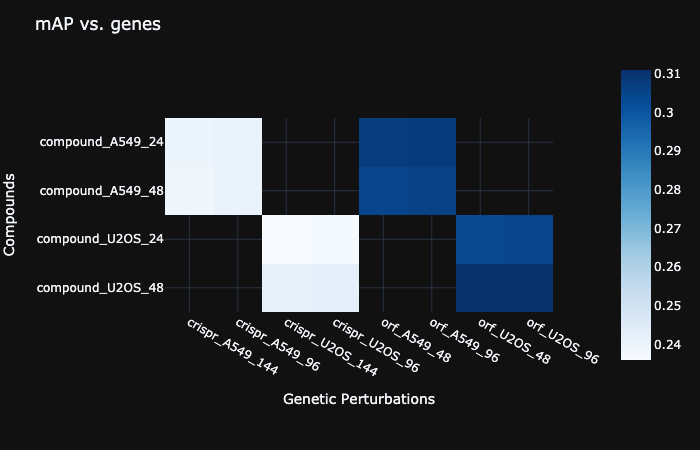

In [6]:
mean_average_precision_df[['Chemical_Perturbation','Genetic_Perturbation']] = mean_average_precision_df.Description.str.split(' vs. ', expand=True,)
mean_average_precision_df['mAP'] = mean_average_precision_df['mAP'].astype(float)
mean_average_precision_df['mAPk'] = mean_average_precision_df['mAPk'].astype(float)
mean_average_precision_df['mAPr'] = mean_average_precision_df['mAPr'].astype(float)
pivot_table = (
    mean_average_precision_df
        .query('Matches=="Real"')
        .pivot('Chemical_Perturbation','Genetic_Perturbation','mAP')
)
fig = px.imshow(pivot_table, color_continuous_scale='blues')
fig.update_layout(title='mAP vs. genes',
                  xaxis=dict(title='Genetic Perturbations'),
                  yaxis=dict(title='Compounds'),
                  coloraxis_colorbar_x=+1.15)
fig.show("png")
fig.write_image(f'figures/11.mAP_heatmap.png', width=640, height=480, scale=2)

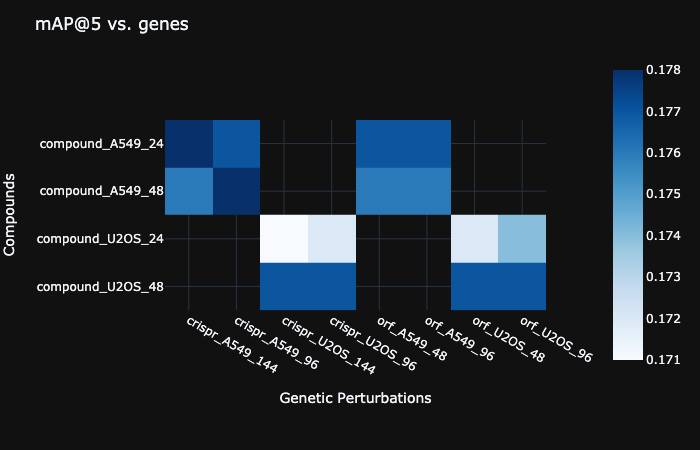

In [7]:
pivot_table = (
    mean_average_precision_df
        .query('Matches=="Real"')
        .pivot('Chemical_Perturbation','Genetic_Perturbation','mAPk')
)
fig = px.imshow(pivot_table, color_continuous_scale='blues')
fig.update_layout(title=f'mAP@{k} vs. genes',
                  xaxis=dict(title='Genetic Perturbations'),
                  yaxis=dict(title='Compounds'),
                  coloraxis_colorbar_x=+1.15)
fig.show("png")
fig.write_image(f'figures/11.mAPk_heatmap.png', width=640, height=480, scale=2)

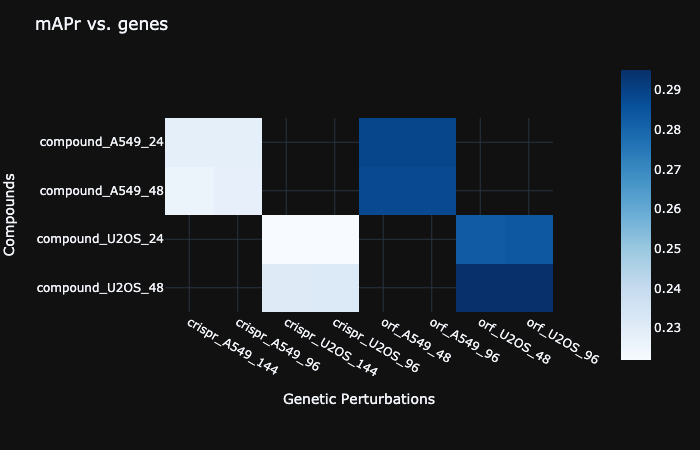

In [8]:
pivot_table = (
    mean_average_precision_df
        .query('Matches=="Real"')
        .pivot('Chemical_Perturbation','Genetic_Perturbation','mAPr')
)
fig = px.imshow(pivot_table, color_continuous_scale='blues')
fig.update_layout(title='mAPr vs. genes',
                  xaxis=dict(title='Genetic Perturbations'),
                  yaxis=dict(title='Compounds'),
                  coloraxis_colorbar_x=+1.15)
fig.show("png")
fig.write_image(f'figures/11.mAPr_heatmap.png', width=640, height=480, scale=2)

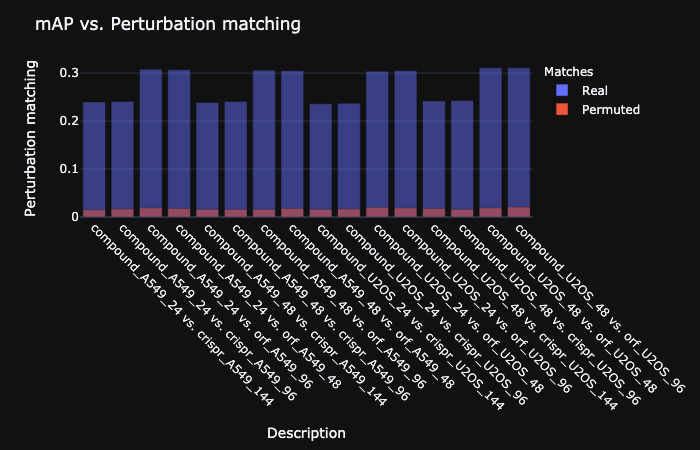

In [9]:
fig = px.bar(data_frame=mean_average_precision_df,
             x='Description',
             y='mAP',
             barmode='overlay',
             color='Matches')
fig.update_layout(title='mAP vs. Perturbation matching',
                  yaxis=dict(title='Perturbation matching'))
fig.update_xaxes(tickangle=45)
fig.show("png")
fig.write_image(f'figures/11.mAP_matching.png', width=640, height=480, scale=2)

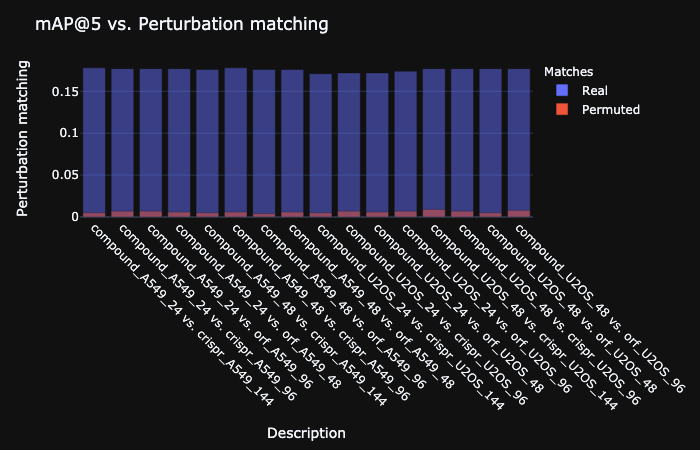

In [10]:
fig = px.bar(data_frame=mean_average_precision_df,
             x='Description',
             y='mAPk',
             barmode='overlay',
             color='Matches')
fig.update_layout(title=f'mAP@{k} vs. Perturbation matching',
                  yaxis=dict(title='Perturbation matching'))
fig.update_xaxes(tickangle=45)
fig.show("png")
fig.write_image(f'figures/11.mAPk_matching.png', width=640, height=480, scale=2)

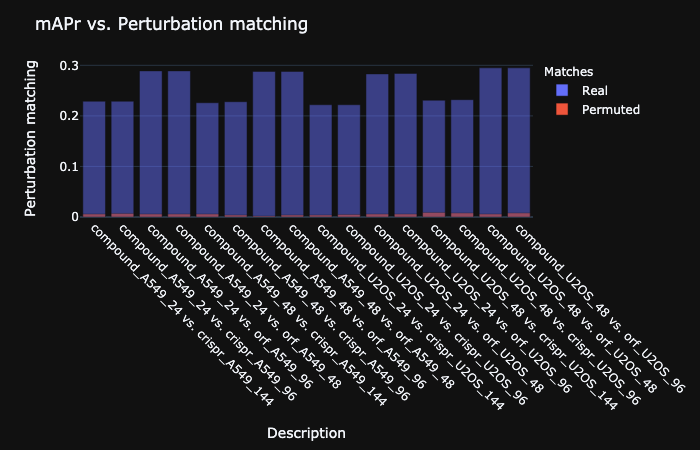

In [11]:
fig = px.bar(data_frame=mean_average_precision_df,
             x='Description',
             y='mAPr',
             barmode='overlay',
             color='Matches')
fig.update_layout(title='mAPr vs. Perturbation matching',
                  yaxis=dict(title='Perturbation matching'))
fig.update_xaxes(tickangle=45)
fig.show("png")
fig.write_image(f'figures/11.mAPr_matching.png', width=640, height=480, scale=2)